# Homework 2

In [19]:
# Import needed packages

import numpy as np
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
%matplotlib inline

In [2]:
# Read data set

data = pd.read_table("speech_data_extend.txt",encoding="utf-8")
print(data.shape)
data.head()

(23155, 3)


,president,speech,year
0,Washington,Fellow-Citizens of the Senate and House of Rep...,1790
1,Washington,I embrace with great satisfaction the opportun...,1790
2,Washington,In resuming your consultations for the general...,1790
3,Washington,Among the many interesting objects which will ...,1790
4,Washington,"A free people ought not only to be armed, but ...",1790


In [3]:
import topicmodels

In [4]:
data = data[data.year >= 1947]
len(data) # The number of documents (paragraphs of State of the Union Addresses) in the dataset

9488

In [5]:
docsobj = topicmodels.RawDocs(data.speech, "long")

In [6]:
print(data.speech.values[3]) # fourth paragraph (note that Python uses 0-indexing)
print(docsobj.tokens[3])

I come also to welcome you as you take up your duties and to discuss with you the manner in which you and I should fulfill our obligations to the American people during the next 2 years. 
['i', 'come', 'also', 'to', 'welcome', 'you', 'as', 'you', 'take', 'up', 'your', 'duties', 'and', 'to', 'discuss', 'with', 'you', 'the', 'manner', 'in', 'which', 'you', 'and', 'i', 'should', 'fulfill', 'our', 'obligations', 'to', 'the', 'american', 'people', 'during', 'the', 'next', '2', 'years', '.']


In [7]:
docsobj.token_clean(1)

In [8]:
print(docsobj.tokens[3])

['come', 'also', 'to', 'welcome', 'you', 'as', 'you', 'take', 'up', 'your', 'duties', 'and', 'to', 'discuss', 'with', 'you', 'the', 'manner', 'in', 'which', 'you', 'and', 'should', 'fulfill', 'our', 'obligations', 'to', 'the', 'american', 'people', 'during', 'the', 'next', 'years']


In [9]:
docsobj.stopword_remove("tokens")
print(docsobj.tokens[3])

['come', 'welcome', 'duties', 'discuss', 'manner', 'fulfill', 'obligations', 'american', 'people', 'next', 'years']


In [10]:
docsobj.stem()
print(docsobj.stems[3])
docsobj.stopword_remove("stems")

['come', 'welcom', 'duti', 'discuss', 'manner', 'fulfil', 'oblig', 'american', 'peopl', 'next', 'year']


In [11]:
docsobj.term_rank("stems")

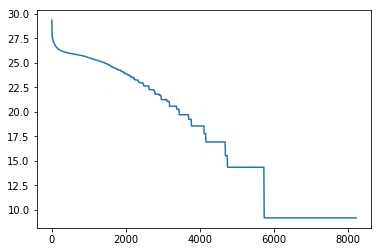

In [12]:
plt.plot([x[1] for x in docsobj.tfidf_ranking])

In [13]:
docsobj.rank_remove("tfidf","stems",docsobj.tfidf_ranking[5000][1])
all_stems = [s for d in docsobj.stems for s in d]
print("number of unique stems = %d" % len(set(all_stems)))
print("number of total stems = %d" % len(all_stems))

number of unique stems = 4742
number of total stems = 250000


In [14]:
len(docsobj.stems)

9488

In [15]:
list(zip([1,2],[4,5]))

[(1, 4), (2, 5)]

In [16]:
len(docsobj.stems[0])

8

In [79]:
all_stems = list(set(all_stems))

In [85]:
Nd = len([stem for doc in docsobj.stems for stem in doc])

# Uncollapsed Gibbs sampler

In [17]:
K = 30
D = len(docsobj.stems)
V = len(set(all_stems))

# Initialise params

eta = 200/V
alpha = 50/K

betas = np.zeros(shape=(K,V))
for i in range(K):
    beta = np.random.uniform(0,1,V)
    beta = beta/np.sum(beta)
    betas[i,:] = beta

thetas = np.zeros(shape=(D,K))
for i in range(D):
    theta = np.random.uniform(0,1,K)
    theta = theta/np.sum(theta)
    thetas[i,:] = theta
    
Z = np.zeros(shape=(D,V))

for i in tqdm(range(D)):
    for j in range(V):
        den = np.dot(thetas[i,:],betas[:,j])
        z_dn = [(thetas[i,k]*betas[k,j])/den for k in range(K)]
        Z[i,j] = np.random.choice(K, 1, z_dn)
        
thetas = np.zeros(shape=(D,K))
N = np.zeros(shape=(D,K))
for i in tqdm(range(D)):
    counts = Counter(Z[i])
    N[i] = [counts[j] for j in range(K)]
    theta = np.random.dirichlet(alpha=alpha + N[i], size=1)
    thetas[i,:] = theta
    
betas = np.zeros(shape=(K,V))
M = np.zeros(shape=(K,V))
for i in range(V):
    counts = Counter(Z[:,i])
    for j in range(K):
        M[j,i] = M[j,i] + counts[j]

for i in tqdm(range(K)):
    beta = np.random.dirichlet(alpha=eta + M[i], size=1)
    betas[i,:] = beta

100%|██████████| 9488/9488 [24:01<00:00,  7.38it/s]


In [65]:
beta_hat = np.zeros(shape=(K,V))
for i in tqdm(range(K)):
    den = (M[i,:]+eta).sum()
    for j in range(V):
        beta_hat[i,j] = (M[i,j] + eta)/den

100%|██████████| 30/30 [00:00<00:00, 298.89it/s]


In [67]:
theta_hat = np.zeros(shape=(D,K))
for i in tqdm(range(D)):
    den = (N[i,:]+alpha).sum()
    for j in range(K):
        theta_hat[i,j] = (N[i,j] + alpha)/den

100%|██████████| 9488/9488 [00:00<00:00, 49664.49it/s]


In [86]:
s1 = 0
for d in tqdm(range(D)):
    s2 = 0
    counts = Counter(docsobj.stems[d])
    for v in range(V):
        s2 = s2 + counts[all_stems[v]] * np.log(np.dot(theta_hat[d,:],beta_hat[:,v]))
    s1 = s1 + s2
num = -1 * s1
den = Nd
perplex = np.exp(num/den)

100%|██████████| 9488/9488 [02:40<00:00, 59.25it/s]


In [87]:
perplex

4742.0069972756146